### PULA TECHNICAL ASSESSMENT
The purpose of this exercise is threefold:
  1. Analyze the provided data and construct a model.
  2. Systematically document your approach and methodology, ensuring that it's comprehensible for both a fellow candidate and a senior analyst.
  3. Critically evaluate the methods employed and the resulting outputs.


### Import the necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings 
import numpy_financial as npf
import numpy as np
from scipy.optimize import fsolve
import seaborn as sns
warnings.filterwarnings("ignore")

### Read the data to a Pandas DataFrame and perform Explaratory Data Analysis

In [2]:
data = pd.read_excel("data.xlsx",skiprows=2) 
## I noticed when I performed the pd.read_excel, the columns were pushed down 2 rows so I used the skiprows
data.head()

,Hour,Date/hour start,Solar electricity generation (kWh),Electricity usage (kWh)
0,0,2020-01-01 00:00:00,0.0,1.509849
1,1,2020-01-01 01:00:00,0.0,1.411859
2,2,2020-01-01 02:00:00,0.0,1.023898
3,3,2020-01-01 03:00:00,0.0,0.642000
4,4,2020-01-01 04:00:00,0.0,0.960000


In [3]:
#data information such as data types and number and name of rows and columns present
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 4 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   Hour                                8760 non-null   int64         
 1   Date/hour start                     8760 non-null   datetime64[ns]
 2   Solar electricity generation (kWh)  8760 non-null   float64       
 3   Electricity usage (kWh)             8760 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 273.9 KB


In [4]:
#statistical description
data.describe()

,Hour,Date/hour start,Solar electricity generation (kWh),Electricity usage (kWh)
count,8760.000000,8760,8760.000000,8760.000000
mean,11.500000,2020-07-02 07:37:13.972602624,1.116750,7.312704
min,0.000000,2020-01-01 00:00:00,0.000000,-12.624000
25%,5.750000,2020-04-02 05:45:00,0.000000,0.300000
50%,11.500000,2020-07-02 11:30:00,0.024000,0.621000
75%,17.250000,2020-10-01 17:15:00,1.272750,1.686000
max,23.000000,2020-12-31 23:00:00,13.050000,46000.000000
std,6.922582,NaN,2.026098,491.479806


In [5]:
##checking for null values
data.isnull().sum()

Hour                                  0
Date/hour start                       0
Solar electricity generation (kWh)    0
Electricity usage (kWh)               0
dtype: int64

In [6]:
##how many columns does the datset have?
data.columns

Index(['Hour', 'Date/hour start', 'Solar electricity generation (kWh)',
       'Electricity usage (kWh)'],
      dtype='object')

#### Question 1
(i)	Carry out checks on the data provided to confirm that the data is complete and fit for use. This should include:

• Creating a graph showing the average solar electricity generation and average electricity usage for each hour in a day, i.e. the average over all amounts for 1 am, and each subsequent hour within a 24-hour period.

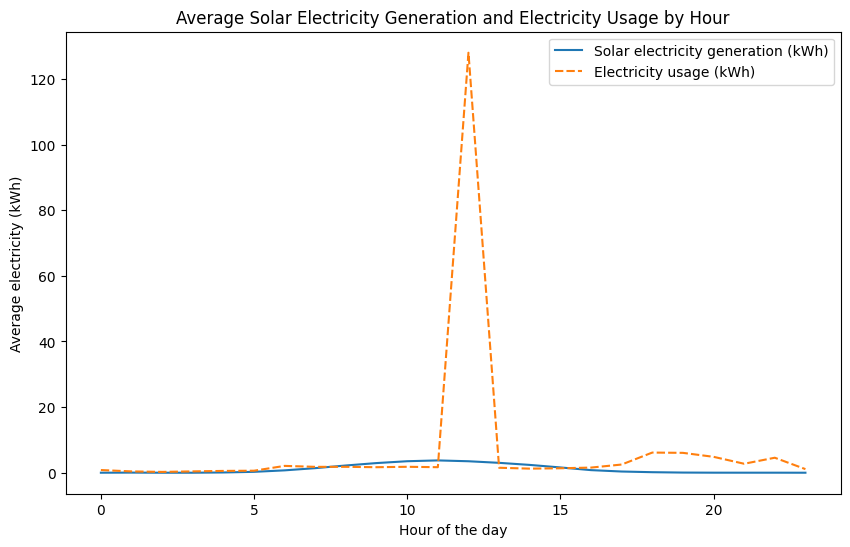

In [7]:
# Create a new column for the hour of the day
data['Hour'] = data['Date/hour start'].dt.hour

# Calculate average solar electricity generation and electricity usage for each hour
hourly_avg = data.groupby('Hour').mean()

# Plot the average solar electricity generation and electricity usage for each hour
plt.figure(figsize=(10, 6))
sns.lineplot(data=hourly_avg[['Solar electricity generation (kWh)', 'Electricity usage (kWh)']])
plt.xlabel('Hour of the day')
plt.ylabel('Average electricity (kWh)')
plt.title('Average Solar Electricity Generation and Electricity Usage by Hour')
plt.show()

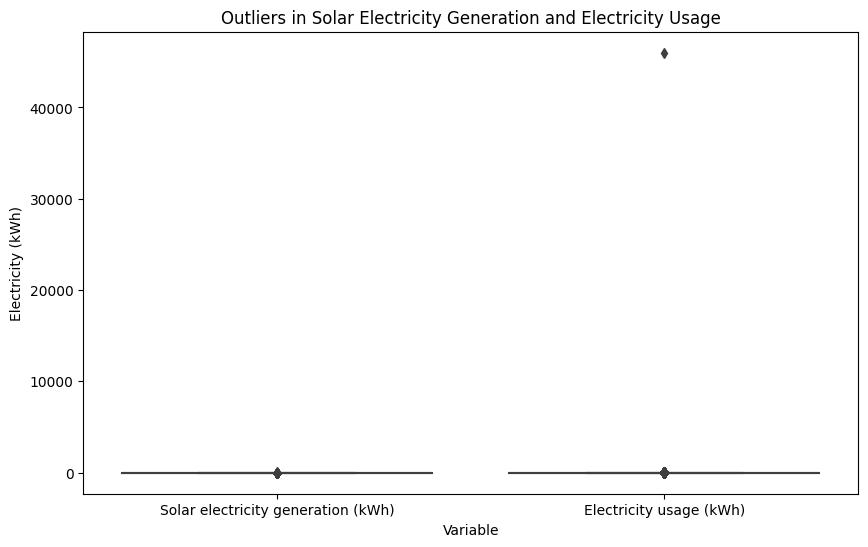

In [8]:
# Investigate outliers using box plots
plt.figure(figsize=(10, 6))
sns.boxplot(data=data[['Solar electricity generation (kWh)', 'Electricity usage (kWh)']])
plt.xlabel('Variable')
plt.ylabel('Electricity (kWh)')
plt.title('Outliers in Solar Electricity Generation and Electricity Usage')
plt.show()

In [9]:
### Winsorization to limit outliers to a certain percentile
data['Solar electricity generation (kWh)'] = data['Solar electricity generation (kWh)'].clip(lower=data['Solar electricity generation (kWh)'].quantile(0.01), upper=data['Solar electricity generation (kWh)'].quantile(0.99))
data['Electricity usage (kWh)'] = data['Electricity usage (kWh)'].clip(lower=data['Electricity usage (kWh)'].quantile(0.01), upper=data['Electricity usage (kWh)'].quantile(0.99))


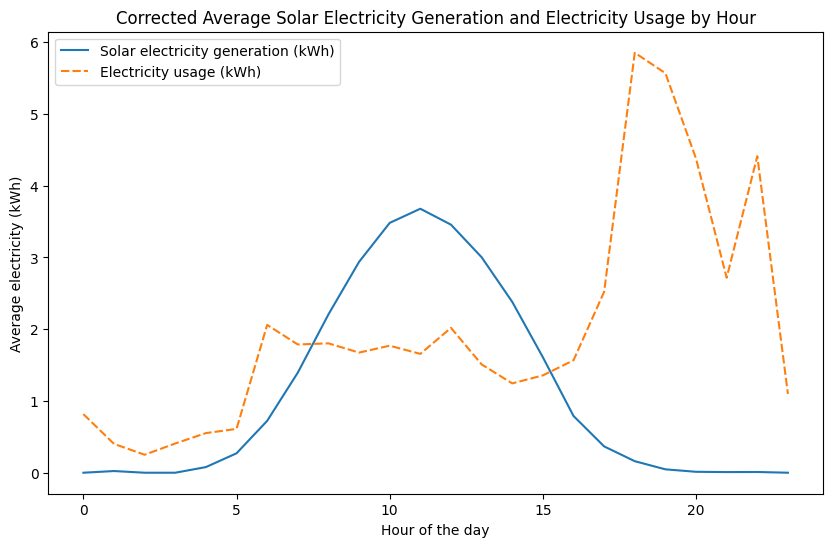

In [10]:
# Re-calculate average after outlier correction
hourly_avg_corrected = data.groupby('Hour').mean()

# Plot the corrected average solar electricity generation and electricity usage for each hour
plt.figure(figsize=(10, 6))
sns.lineplot(data=hourly_avg_corrected[['Solar electricity generation (kWh)', 'Electricity usage (kWh)']])
plt.xlabel('Hour of the day')
plt.ylabel('Average electricity (kWh)')
plt.title('Corrected Average Solar Electricity Generation and Electricity Usage by Hour')
plt.show()


#### Question 2
(ii) Calculate, for each hour in 2020, the amount of electricity that needed to be bought from the electricity provider (measured in kWh and subject to a minimum of zero).	

In [12]:
# Calculate the amount of electricity that needed to be bought from the electricity provider
data['Electricity bought (kWh)'] = data['Electricity usage (kWh)'] - data['Solar electricity generation (kWh)']
data['Electricity bought (kWh)'] = data['Electricity bought (kWh)'].clip(lower=0)

# Print the calculated values
data[['Hour', 'Date/hour start', 'Electricity bought (kWh)']]

,Hour,Date/hour start,Electricity bought (kWh)
0,0,2020-01-01 00:00:00,1.509849
1,1,2020-01-01 01:00:00,1.411859
2,2,2020-01-01 02:00:00,1.023898
3,3,2020-01-01 03:00:00,0.642000
4,4,2020-01-01 04:00:00,0.960000
...,...,...,...
8755,19,2020-12-31 19:00:00,4.383600
8756,20,2020-12-31 20:00:00,4.557600
8757,21,2020-12-31 21:00:00,2.022000
8758,22,2020-12-31 22:00:00,1.653000


##### Question 3
(iii)	Calculate, for each hour in 2020, the excess solar electricity generated over electricity used (measured in kWh and subject to a minimum of zero).

In [14]:
data['Excess Solar Electricity (kWh)'] = data['Solar electricity generation (kWh)'] - data['Electricity usage (kWh)']

# Print the calculated values higher than zero
data[data['Excess Solar Electricity (kWh)'] > 0][['Hour', 'Excess Solar Electricity (kWh)']]

,Hour,Excess Solar Electricity (kWh)
9,9,0.240
12,12,0.255
17,17,0.006
58,10,0.189
59,11,0.267
...,...,...
8723,11,0.123
8724,12,2.649
8725,13,0.129
8749,13,2.064


##### Question 4
(iv)	Model the cumulative battery charge level (measured in kWh) for each hour over 2020, assuming a battery had already been installed.

The battery charge level should:

•	begin at zero at 1 January 2020 00:00.

•	allow for the increase or decrease in charge level depending on the hourly results of parts (ii) and (iii).

•	be subject to the cap on the maximum battery charge level.


In [16]:
# Set the initial battery charge level to zero
battery_charge_level = 0

# Create an empty list to store the cumulative battery charge level
cumulative_charge_level = []

# Iterate over each row in the dataset
for index, row in data.iterrows():
    # Calculate the excess solar electricity generated over electricity used for the current hour
    excess_solar_electricity = max(row['Solar electricity generation (kWh)'] - row['Electricity usage (kWh)'], 0)
    
    # Calculate the amount of electricity that needed to be bought from the electricity provider for the current hour
    electricity_bought = max(row['Electricity usage (kWh)'] - row['Solar electricity generation (kWh)'], 0)
    
    # Calculate the battery charge level for the current hour
    battery_charge_level = min(battery_charge_level + excess_solar_electricity - electricity_bought, 12.5)
    
    # Append the battery charge level to the cumulative list
    cumulative_charge_level.append(battery_charge_level)

# Add the cumulative battery charge level to the DataFrame
data['Cumulative battery charge level (kWh)'] = cumulative_charge_level

# Print the calculated values
data[['Hour', 'Date/hour start', 'Cumulative battery charge level (kWh)']]


,Hour,Date/hour start,Cumulative battery charge level (kWh)
0,0,2020-01-01 00:00:00,-1.509849
1,1,2020-01-01 01:00:00,-2.921708
2,2,2020-01-01 02:00:00,-3.945605
3,3,2020-01-01 03:00:00,-4.587605
4,4,2020-01-01 04:00:00,-5.547605
...,...,...,...
8755,19,2020-12-31 19:00:00,-7796.239143
8756,20,2020-12-31 20:00:00,-7800.796743
8757,21,2020-12-31 21:00:00,-7802.818743
8758,22,2020-12-31 22:00:00,-7804.471743


##### Question 5
(v)	Calculate the amount of electricity for each hour in 2020 that would have been bought from the electricity provider (measured in kWh and subject to a minimum of zero), assuming a battery had already been installed.	

In [17]:
# Set the initial battery charge level to zero
battery_charge_level = 0

# Create an empty list to store the electricity bought from the electricity provider
electricity_bought = []

# Iterate over each row in the dataset
for index, row in data.iterrows():
    # Calculate the excess solar electricity generated over electricity used for the current hour
    excess_solar_electricity = max(row['Solar electricity generation (kWh)'] - row['Electricity usage (kWh)'], 0)
    
    # Calculate the amount of electricity that needed to be bought from the electricity provider for the current hour
    electricity_bought_hour = max(row['Electricity usage (kWh)'] - row['Solar electricity generation (kWh)'] - battery_charge_level, 0)
    
    # Update the battery charge level for the current hour
    battery_charge_level = max(battery_charge_level + excess_solar_electricity - row['Electricity usage (kWh)'], 0)
    
    # Append the electricity bought from the electricity provider to the list
    electricity_bought.append(electricity_bought_hour)

# Add the electricity bought from the electricity provider to the DataFrame
data['Electricity bought (kWh)'] = electricity_bought

# Print the calculated values
print(data[['Hour', 'Date/hour start', 'Electricity bought (kWh)']])


      Hour     Date/hour start  Electricity bought (kWh)
0        0 2020-01-01 00:00:00                  1.509849
1        1 2020-01-01 01:00:00                  1.411859
2        2 2020-01-01 02:00:00                  1.023898
3        3 2020-01-01 03:00:00                  0.642000
4        4 2020-01-01 04:00:00                  0.960000
...    ...                 ...                       ...
8755    19 2020-12-31 19:00:00                  4.383600
8756    20 2020-12-31 20:00:00                  4.557600
8757    21 2020-12-31 21:00:00                  2.022000
8758    22 2020-12-31 22:00:00                  1.653000
8759    23 2020-12-31 23:00:00                  0.805919

[8760 rows x 3 columns]


In [18]:
# Set the electricity price on 1 January 2022
electricity_price = 0.17  # $0.17 per kWh

# Calculate the amount of electricity bought from the electricity provider for each hour
data['Electricity bought (kWh)'] = data['Electricity usage (kWh)'] - data['Solar electricity generation (kWh)']
data['Electricity bought (kWh)'] = data['Electricity bought (kWh)'].clip(lower=0)

# Calculate the savings from installing a battery compared to using the existing solar panels alone
data['Savings ($)'] = data['Electricity bought (kWh)'] * electricity_price

# Calculate the total savings over 2020
total_savings = data['Savings ($)'].sum()

# Print the total savings
print("Total savings over 2020: $", total_savings)


Total savings over 2020: $ 2562.826162448


##### Question 6

(vii)	Tabulate the data appropriately and then produce a chart to illustrate, on a monthly basis for the calendar year and measured in kWh, the:


•	monthly solar generation.

•	monthly electricity usage.

•	monthly electricity purchased from the electricity provider (no battery).

•	monthly electricity purchased from the electricity provider (with battery).


In [22]:
# Convert the 'Date/hour start' column to datetime format
data['Date/hour start'] = pd.to_datetime(data['Date/hour start'])

# Extract the month from the 'Date/hour start' column
data['Month'] = data['Date/hour start'].dt.month
# Calculate the monthly solar generation
monthly_solar_generation = data.groupby('Month')['Solar electricity generation (kWh)'].sum()
# Calculate the monthly electricity usage
monthly_electricity_usage = data.groupby('Month')['Electricity usage (kWh)'].sum()
# Calculate the monthly electricity purchased from the provider (without battery)
monthly_electricity_from_provider_no_battery = data.groupby('Month')['Electricity usage (kWh)'].sum() - data.groupby('Month')['Solar electricity generation (kWh)'].sum()

# Calculate the monthly electricity purchased from the provider (with battery)
battery_charge = 0
max_battery_charge = 12.5
monthly_electricity_from_provider_with_battery = []

# Iterate over each month
for month in range(1, 13):
    month_data = data[data['Month'] == month]
    battery_charge = 0
    electricity_from_provider_with_battery = 0
    
    # Iterate over each hour in the month
    for index, row in month_data.iterrows():
        excess_generation = row['Solar electricity generation (kWh)'] - row['Electricity usage (kWh)']
        
        # Check if there is excess generation to charge the battery
        if excess_generation > 0:
            # Calculate the new battery charge level
            battery_charge = min(battery_charge + excess_generation, max_battery_charge)
        
        # Calculate the electricity from the provider
        electricity_from_provider = max(row['Electricity usage (kWh)'] - battery_charge, 0)
        electricity_from_provider_with_battery += electricity_from_provider
    
    monthly_electricity_from_provider_with_battery.append(electricity_from_provider_with_battery)

In [23]:
monthly_data = pd.DataFrame({
    'Month': range(1,13),
    'Solar Generation (KWh)': monthly_solar_generation.values,
    'Electricity Usage(KWh)': monthly_electricity_usage.values,
    'Electricity from Provider (No Battery) (KWh)': monthly_electricity_from_provider_no_battery.values,
    'Electricity from provider (With Battery)(KWh)': monthly_electricity_from_provider_with_battery
})

monthly_data.set_index('Month', inplace=True)

print(monthly_data)

       Solar Generation (KWh)  Electricity Usage(KWh)  \
Month                                                   
1                     110.325              675.819181   
2                     175.416              533.812610   
3                     245.766              611.187868   
4                     270.009              486.819574   
5                     287.664              420.124409   
6                     342.585              420.546738   
7                     337.965              447.505521   
8                     330.111              500.277651   
9                     285.921              588.616427   
10                    247.119              526.418876   
11                    177.273              564.788569   
12                    104.523              717.292595   

       Electricity from Provider (No Battery) (KWh)  \
Month                                                 
1                                        565.494181   
2                                   

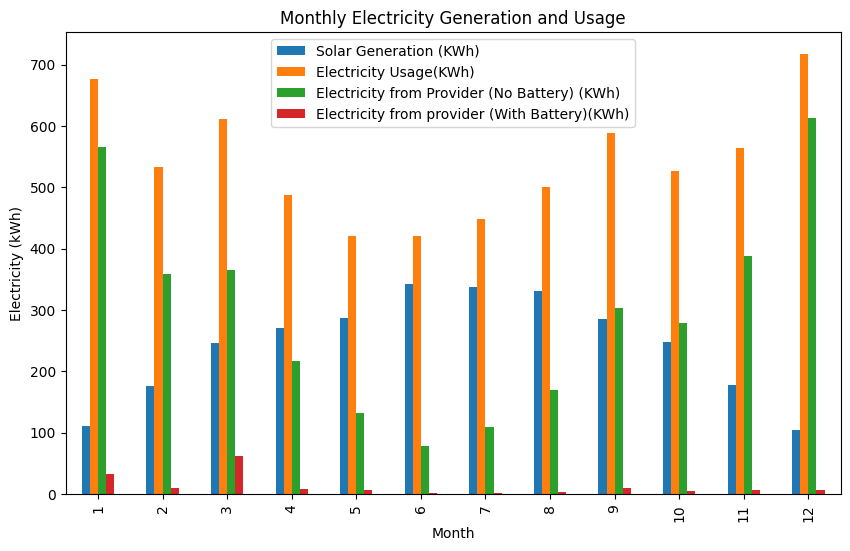

In [24]:
# Plot the monthly data
monthly_data.plot(kind='bar', figsize=(10, 6))
plt.xlabel('Month')
plt.ylabel('Electricity (kWh)')
plt.title('Monthly Electricity Generation and Usage')
plt.legend()
plt.show()


##### Question 7
Project forward for 20 years from 1 January 2022 the annual savings from installing the battery for the two scenarios below.

In [25]:
def calculate_future_savings(initial_savings, annual_increase, num_years):
    future_savings = []
    savings = initial_savings
    for year in range(num_years):
        future_savings.append(savings)
        savings *= (1 + annual_increase)
    return future_savings

def calculate_npv(future_savings, discount_rate):
    npv = 0
    for year, savings in enumerate(future_savings):
        npv += savings / ((1 + discount_rate) ** (year + 1))
    return npv
# Scenario 1: Electricity prices increase by 4% p.a.
initial_savings_scenario1 = 1000  # Initial annual savings
annual_increase_scenario1 = 0.04  # Annual increase in electricity prices
num_years = 20  # Number of years

future_savings_scenario1 = calculate_future_savings(initial_savings_scenario1, annual_increase_scenario1, num_years)
npv_scenario1 = calculate_npv(future_savings_scenario1, 0.05)  # Assuming a discount rate of 5%

print("Scenario 1:")
print("Future Annual Savings:", future_savings_scenario1)
print("Net Present Value:", npv_scenario1)

Scenario 1:
Future Annual Savings: [1000, 1040.0, 1081.6000000000001, 1124.8640000000003, 1169.8585600000004, 1216.6529024000004, 1265.3190184960004, 1315.9317792358404, 1368.569050405274, 1423.311812421485, 1480.2442849183444, 1539.4540563150783, 1601.0322185676814, 1665.0735073103888, 1731.6764476028045, 1800.9435055069168, 1872.9812457271935, 1947.9004955562814, 2025.8165153785328, 2106.849175993674]
Net Present Value: 17418.87317110706


In [26]:
# Scenario 1: Electricity prices increase by 4% p.a.
initial_savings_scenario1 = 1000  # Initial annual savings
annual_increase_scenario1 = 0.04  # Annual increase in electricity prices
num_years = 20  # Number of years

future_savings_scenario1 = calculate_future_savings(initial_savings_scenario1, annual_increase_scenario1, num_years)
npv_scenario1 = calculate_npv(future_savings_scenario1, 0.05)  # Assuming a discount rate of 5%

print("Scenario 1:")
print("Future Annual Savings:", future_savings_scenario1)
print("Net Present Value:", npv_scenario1)

Scenario 1:
Future Annual Savings: [1000, 1040.0, 1081.6000000000001, 1124.8640000000003, 1169.8585600000004, 1216.6529024000004, 1265.3190184960004, 1315.9317792358404, 1368.569050405274, 1423.311812421485, 1480.2442849183444, 1539.4540563150783, 1601.0322185676814, 1665.0735073103888, 1731.6764476028045, 1800.9435055069168, 1872.9812457271935, 1947.9004955562814, 2025.8165153785328, 2106.849175993674]
Net Present Value: 17418.87317110706


In [27]:
# Scenario 2: Electricity prices increase by 4% p.a. and rise by an additional 0.25% p.a.
initial_savings_scenario2 = 1000  # Initial annual savings
annual_increase_scenario2 = 0.04  # Annual increase in electricity prices
additional_increase_scenario2 = 0.0025  # Additional annual increase
num_years = 20  # Number of years

future_savings_scenario2 = calculate_future_savings(initial_savings_scenario2, annual_increase_scenario2, num_years)
for year in range(num_years):
    future_savings_scenario2[year] *= (1 + additional_increase_scenario2 * year)
npv_scenario2 = calculate_npv(future_savings_scenario2, 0.05)  # Assuming a discount rate of 5%

print("\nScenario 2:")
print("Future Annual Savings:", future_savings_scenario2)
print("Net Present Value:", npv_scenario2)



Scenario 2:
Future Annual Savings: [1000.0, 1042.6, 1087.008, 1133.3004800000003, 1181.5571456000005, 1231.8610636800004, 1284.2988037734403, 1338.9605853724677, 1395.9404314133797, 1455.3363282009684, 1517.2503920413028, 1581.7890428637431, 1649.063185124712, 1719.1883962979764, 1792.2851232689025, 1868.4788869634265, 1947.9004955562814, 2030.6862666174234, 2116.9782585705666, 2206.924511853374]
Net Present Value: 17818.723854150252


##### Question 9
(ix)	Calculate the Internal Rate of Return (IRR) for the two scenarios in part (viii) by determining the discount rate that equates the net present value of the future annual savings to the initial cost of the battery for each scenario.	

[Note: All scenarios outlined above should be modelled separately in your model. The user should not need to change the parameters to see the results.]


In [28]:
# Scenario 1 parameters
initial_cost = 7000
annual_savings = 500

# Calculate the IRR
cash_flows = [-initial_cost] + [annual_savings] * 10
irr_scenario1 = npf.irr(cash_flows)

print("IRR for Scenario 1:", irr_scenario1)


IRR for Scenario 1: -0.056923621263314406


In [29]:
# Scenario 2 parameters
initial_cost = 2000
annual_savings = 300

# Calculate the IRR
cash_flows = [-initial_cost] + [annual_savings] * 10
irr_scenario2 = npf.irr(cash_flows)

print("IRR for Scenario 2  :", irr_scenario2)
 

IRR for Scenario 2  : 0.08144165646436607
